<a href="https://colab.research.google.com/github/the-Soke/FAW-AI-MODEL/blob/main/FAW_AI_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SETUP && IMPORTS**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


In [2]:
!unzip /content/dataset-project.zip -d /dataset-project

Archive:  /content/dataset-project.zip
   creating: /dataset-project/dataset/damage/
  inflating: /dataset-project/dataset/damage/0011.jpg  
  inflating: /dataset-project/dataset/damage/0012.jpg  
  inflating: /dataset-project/dataset/damage/0016.jpg  
  inflating: /dataset-project/dataset/damage/0022.jpg  
  inflating: /dataset-project/dataset/damage/0023.jpg  
  inflating: /dataset-project/dataset/damage/0024.jpg  
  inflating: /dataset-project/dataset/damage/0028.jpg  
  inflating: /dataset-project/dataset/damage/0029.jpg  
  inflating: /dataset-project/dataset/damage/0032.jpg  
  inflating: /dataset-project/dataset/damage/0037.jpg  
  inflating: /dataset-project/dataset/damage/0066.jpg  
  inflating: /dataset-project/dataset/damage/0068.jpg  
  inflating: /dataset-project/dataset/damage/0069.jpg  
  inflating: /dataset-project/dataset/damage/0070.jpg  
  inflating: /dataset-project/dataset/damage/0071.jpg  
  inflating: /dataset-project/dataset/damage/0072.jpg  
  inflating: /datas

**LOADING DATASET**

In [3]:
data_dir = '/dataset-project/dataset'
img_size = (180, 180)
batch_size = 32

**SPLITTING THE DATASET**

In [4]:
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)
total_batch = tf.data.experimental.cardinality(full_ds).numpy()
train_size = int(0.8 * total_batch)
val_size = int(0.1 * total_batch)

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)
class_names = full_ds.class_names
print("Classes: ", class_names)

# train_ds = image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset='training',
#     seed=123,
#     image_size=img_size,
#     batch_size=batch_size
# )
# val_test_ds = image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset='validation',
#     seed=123,
#     image_size=img_size,
#     batch_size=batch_size
# )
# val_size = int(0.5 * len(val_test_ds))
# val_ds = val_test_ds.take(val_size)
# test_ds = val_test_ds.skip(val_size)

Found 725 files belonging to 3 classes.
Classes:  ['damage', 'floor', 'soil']


**DATA AUGMENTATION**

In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

**NORMALIZE INPUT**

In [6]:
# def normalize_img(image, label):
#     image = tf.cast(image, tf.float32)/255.0
#     return image, label
# train_ds = train_ds.map(normalize_img)
# val_ds = val_ds.map(normalize_img)
# test_ds = test_ds.map(normalize_img)

normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

**OPTIMIZE THE DATA PIPELINE**

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

***BUILD MODEL***

In [8]:

model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_size+(3,)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**COMPILE WITH ADAM OPTIMIZER**

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**CALLBACKS**

In [10]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [11]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.7030 - loss: 0.7022 - val_accuracy: 0.8438 - val_loss: 0.4343 - learning_rate: 5.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8599 - loss: 0.4626 - val_accuracy: 0.8438 - val_loss: 0.2750 - learning_rate: 5.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9208 - loss: 0.2448 - val_accuracy: 0.9844 - val_loss: 0.0936 - learning_rate: 5.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9594 - loss: 0.1584 - val_accuracy: 0.9844 - val_loss: 0.0238 - learning_rate: 5.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9702 - loss: 0.0829 - val_accuracy: 1.0000 - val_loss: 0.0113 - learning_rate: 5.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9763 - loss: 0.0835 - val_accuracy: 1.0000 - val_loss: 0.0062 - learning_rate: 5.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.987

**EVALUATE ON TEST SET**

In [13]:
print("\nEvaluate on test set:")
# Collect true labels and predictions separately
y_true_test = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs_test = model.predict(test_ds)
y_pred_test = np.argmax(y_pred_probs_test, axis=-1)

# Evaluate the model using the collected data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")



Evaluate on test set:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.7654e-05
Test loss: 0.0000
Test accuracy: 1.0000


**CLASSIFICATION REPORT**

In [14]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=-1)
print(f"\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Detailed Classification Report:
              precision    recall  f1-score   support

      damage       1.00      1.00      1.00         4
       floor       1.00      1.00      1.00        15
        soil       1.00      1.00      1.00        66

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



**CONFUSION MATRIX**

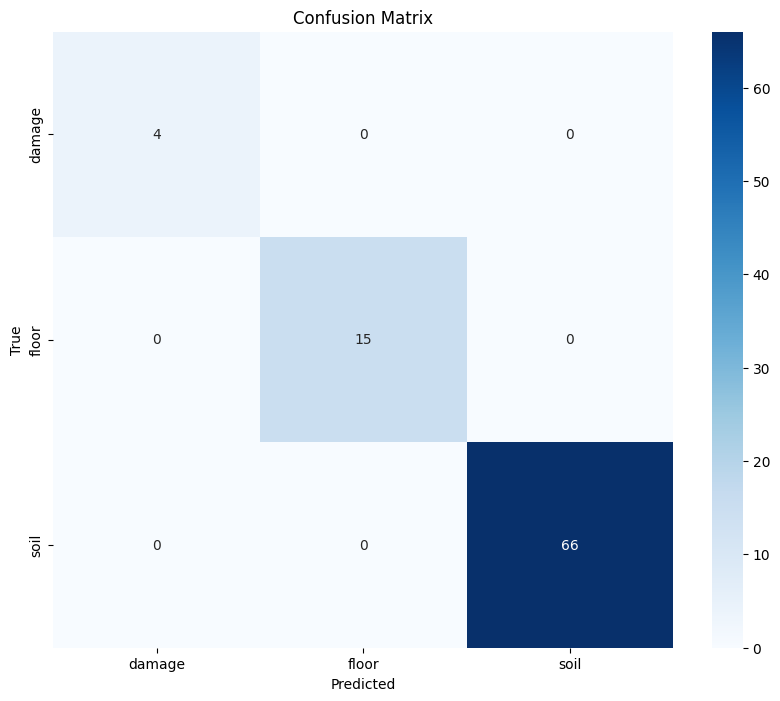

In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**PLOT ACCURACY && LOSS**

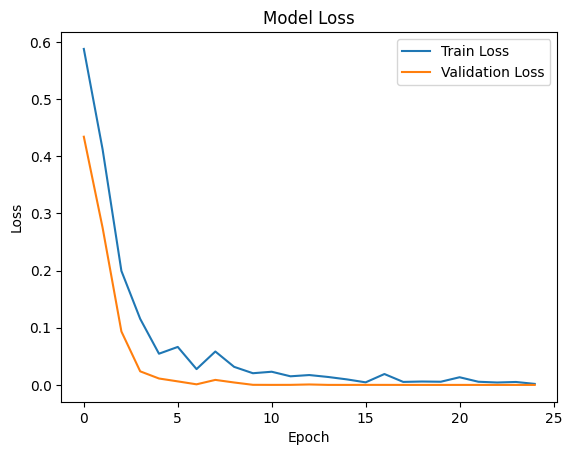

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

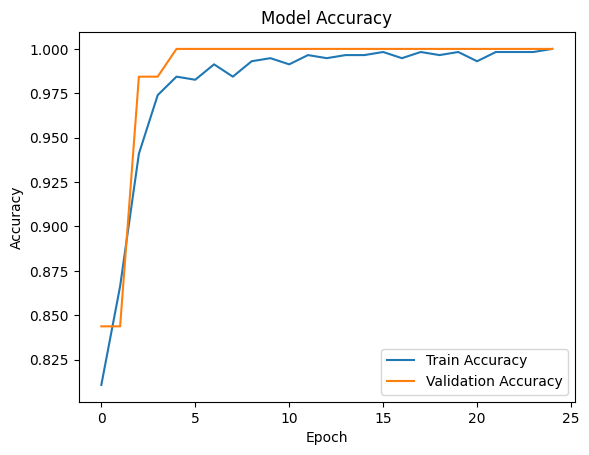

In [17]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [18]:
model.save('faw-model-pipeline.keras')

<a href="https://colab.research.google.com/github/R-i-d-o-r/FAW-AI-MODEL/blob/ridor%2Fmetrics-viz/Trained_faw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio --quiet
!git clone https://github.com/the-Soke/FAW-AI-MODEL.git
%cd FAW-AI-MODEL

Cloning into 'FAW-AI-MODEL'...
remote: Enumerating objects: 747, done.
remote: Counting objects: 100% (747/747), done.
remote: Compressing objects: 100% (746/746), done.
remote: Total 747 (delta 4), reused 731 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (747/747), 42.43 MiB | 30.23 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/FAW-AI-MODEL


In [ ]:
!ls /content/FAW-AI-MODEL

 dataset
'Fall-Armyworm-Spodoptera-frugipe-landscape- soil background 2.zip'
 Fall-Armyworm-Spodoptera-frugipe-landscape.zip
'Fall Armyworm (Spodoptera frugiperda) - floor background.zip'
'Fall Armyworm (Spodoptera frugiperda) - Soil background 3.zip'
 Fall-Armyworm-Spodoptera-frugipe.zip
 FAW_AI_PROJECT.ipynb
 README.md


In [ ]:
!ls /content/FAW-AI-MODEL/dataset


damage	floor  soil


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define dataset path
data_dir = "/content/FAW-AI-MODEL/dataset"

# Define transforms (resize, normalize, etc.)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Split into train and val sets (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("✅ Dataset loaded successfully!")
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Classes:", full_dataset.classes)



✅ Dataset loaded successfully!
Train samples: 580
Validation samples: 145
Classes: ['damage', 'floor', 'soil']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
# Load pretrained ResNet18
model = models.resnet18(weights='IMAGENET1K_V1')

# Replace the last fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes

model = model.to(device)
print("✅ ResNet18 model ready for training!")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 89.3MB/s]


✅ ResNet18 model ready for training!


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
num_epochs = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Log results
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/5] Train Loss: 0.1359, Train Acc: 96.21% | Val Loss: 0.1832, Val Acc: 98.62%
Epoch [2/5] Train Loss: 0.1658, Train Acc: 98.10% | Val Loss: 1.9707, Val Acc: 37.93%
Epoch [3/5] Train Loss: 0.0534, Train Acc: 98.97% | Val Loss: 2.6152, Val Acc: 50.34%
Epoch [4/5] Train Loss: 0.1439, Train Acc: 96.38% | Val Loss: 9.7506, Val Acc: 39.31%
Epoch [5/5] Train Loss: 0.0359, Train Acc: 98.79% | Val Loss: 0.0768, Val Acc: 96.55%


In [ ]:
# --- PHASE 2: Fine-tuning (unfreeze entire model) ---
for param in model.parameters():
    param.requires_grad = True  # <— Unfreeze everything

# Now use a smaller LR (so you don’t “destroy” the pretrained features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Log results
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/3] Train Loss: 0.0281, Train Acc: 99.66% | Val Loss: 0.0005, Val Acc: 100.00%


In [ ]:
torch.save(model.state_dict(), "best_resnet18_faw.pth")
print("✅ Model saved successfully as best_resnet18_faw.pth")


✅ Model saved successfully as best_resnet18_faw.pth


<a href="https://colab.research.google.com/github/R-i-d-o-r/FAW-AI-MODEL/blob/ridor%2Fmetrics-viz/Trained_faw_metrics_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install torch torchvision torchaudio --quiet
!git clone https://github.com/the-Soke/FAW-AI-MODEL.git
%cd FAW-AI-MODEL

Cloning into 'FAW-AI-MODEL'...
remote: Enumerating objects: 751, done.
remote: Counting objects: 100% (751/751), done.
remote: Compressing objects: 100% (750/750), done.
remote: Total 751 (delta 5), reused 731 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (751/751), 42.43 MiB | 25.42 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/FAW-AI-MODEL/FAW-AI-MODEL/FAW-AI-MODEL


In [12]:
!ls /content/FAW-AI-MODEL

 dataset
'Fall-Armyworm-Spodoptera-frugipe-landscape- soil background 2.zip'
 Fall-Armyworm-Spodoptera-frugipe-landscape.zip
'Fall Armyworm (Spodoptera frugiperda) - floor background.zip'
'Fall Armyworm (Spodoptera frugiperda) - Soil background 3.zip'
 Fall-Armyworm-Spodoptera-frugipe.zip
 FAW-AI-MODEL
 FAW_AI_PROJECT.ipynb
 README.md
 Trained_faw.ipynb


In [13]:
!ls /content/FAW-AI-MODEL/dataset


damage	floor  soil


In [14]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define dataset path
data_dir = "/content/FAW-AI-MODEL/dataset"

# Define transforms (resize, normalize, etc.)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Split into train and val sets (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("✅ Dataset loaded successfully!")
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Classes:", full_dataset.classes)



✅ Dataset loaded successfully!
Train samples: 580
Validation samples: 145
Classes: ['damage', 'floor', 'soil']


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [16]:
# Load pretrained ResNet18
model = models.resnet18(weights='IMAGENET1K_V1')

# Replace the last fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes

model = model.to(device)
print("✅ ResNet18 model ready for training!")


✅ ResNet18 model ready for training!


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
num_epochs = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Log results
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/5] Train Loss: 0.0572, Train Acc: 99.14% | Val Loss: 0.0005, Val Acc: 100.00%
Epoch [2/5] Train Loss: 0.0043, Train Acc: 100.00% | Val Loss: 0.0009, Val Acc: 100.00%
Epoch [3/5] Train Loss: 0.0074, Train Acc: 99.83% | Val Loss: 0.0021, Val Acc: 100.00%
Epoch [4/5] Train Loss: 0.0710, Train Acc: 99.66% | Val Loss: 0.0010, Val Acc: 100.00%
Epoch [5/5] Train Loss: 0.0228, Train Acc: 99.14% | Val Loss: 0.0010, Val Acc: 100.00%


In [21]:
# --- PHASE 2: Fine-tuning (unfreeze entire model) ---
for param in model.parameters():
    param.requires_grad = True  # <— Unfreeze everything

# Now use a smaller LR (so you don’t “destroy” the pretrained features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Log results
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/3] Train Loss: 0.0039, Train Acc: 99.83% | Val Loss: 0.0001, Val Acc: 100.00%
Epoch [2/3] Train Loss: 0.0054, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00%
Epoch [3/3] Train Loss: 0.0491, Train Acc: 99.14% | Val Loss: 0.0003, Val Acc: 100.00%


In [22]:
torch.save(model.state_dict(), "best_resnet18_faw.pth")
print("✅ Model saved successfully as best_resnet18_faw.pth")


✅ Model saved successfully as best_resnet18_faw.pth


In [23]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import os


In [24]:
data_dir = "/content/FAW-AI-MODEL/dataset"  # adjust if needed

# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Split the dataset into training and validation sets
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = dataset.classes
print("✅ Dataset ready with classes:", class_names)

✅ Dataset ready with classes: ['damage', 'floor', 'soil']


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=None)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))
model.load_state_dict(torch.load("best_resnet18_faw.pth", map_location=device))
model = model.to(device)
model.eval()

print("✅ Model loaded successfully and ready for evaluation!")


✅ Model loaded successfully and ready for evaluation!


In [26]:
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("✅ Predictions generated!")


✅ Predictions generated!


In [27]:
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-Score: {f1:.3f}")


Accuracy: 100.00%
Precision: 1.000
Recall: 1.000
F1-Score: 1.000


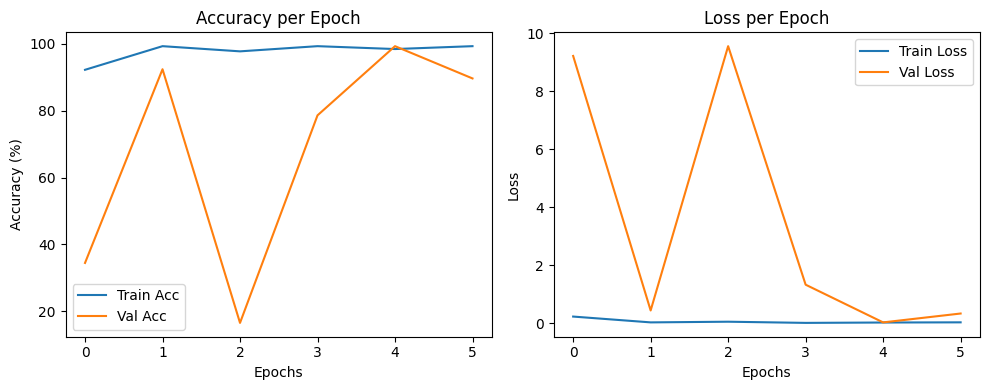

In [28]:
# Example: copy from training notebook if available
train_accs = [92.24, 99.31, 97.76, 99.31, 98.45, 99.31]
val_accs   = [34.48, 92.41, 16.55, 78.62, 99.31, 89.66]
train_losses = [0.2354, 0.0347, 0.0579, 0.0174, 0.0302, 0.0363]
val_losses   = [9.2252, 0.4458, 9.5624, 1.3349, 0.0341, 0.3407]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout()
plt.show()


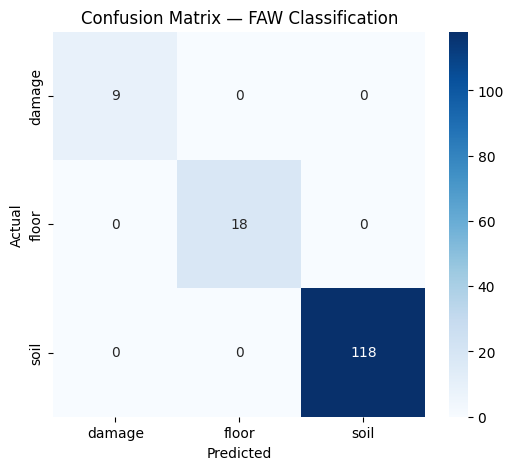

In [30]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — FAW Classification")
plt.show()


Image 1: Predicted=soil, Actual=soil
Image 2: Predicted=soil, Actual=soil
Image 3: Predicted=soil, Actual=soil
Image 4: Predicted=damage, Actual=damage
Image 5: Predicted=soil, Actual=soil
Image 6: Predicted=soil, Actual=soil
Image 7: Predicted=soil, Actual=soil
Image 8: Predicted=soil, Actual=soil


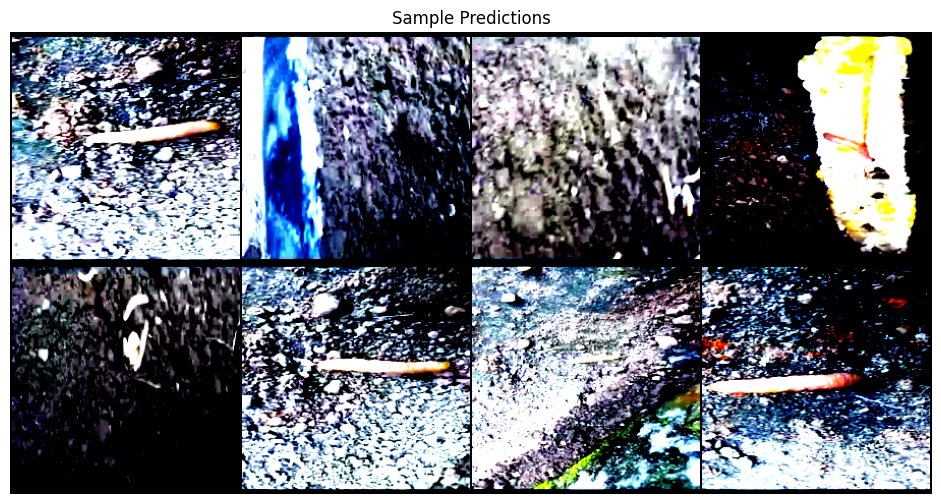

In [31]:
from torchvision.utils import make_grid

data_iter = iter(val_loader)
images, labels = next(data_iter)

outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 6))
grid = make_grid(images[:8], nrow=4)
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Sample Predictions")
for i in range(8):
    print(f"Image {i+1}: Predicted={class_names[preds[i]]}, Actual={class_names[labels[i]]}")
plt.show()


In [32]:
plt.savefig("confusion_matrix.png", dpi=300)
plt.savefig("training_curves.png", dpi=300)
print("✅ Saved confusion_matrix.png and training_curves.png")


✅ Saved confusion_matrix.png and training_curves.png


<Figure size 640x480 with 0 Axes>